In [55]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
import numpy as np
import datetime as dt
import os
import re
# import gtfs_kit_scissors

Der Plan:
- Kreise/Gemeinden
- für >= 2 Datensätze
- für jede Shape den Unterschied berechnen
- Wie sind die Unterschiede verteilt?
- überdurchschnittlich hohe Abweichungen hervorheben
    - MAD? STD?

In [2]:
def resultComparison(comp_gdf, target_gdf):
    
    comp_df = comp_gdf.loc[:,'KRS':'halte.nv'].merge(target_gdf[['AGS','halte.ges','halte.nv']], on='AGS', suffixes=('_0','_1'))

    comp_df['diff.ges'] = comp_df['halte.ges_1']-comp_df['halte.ges_0']
    comp_df['diff.nv'] = comp_df['halte.nv_1']-comp_df['halte.nv_1']
    comp_df['diff.ges.per'] = comp_df['diff.ges']/comp_df['halte.ges_1']
    comp_df['diff.ges.per.abs'] = comp_df['diff.ges.per'].abs()
    comp_df['diff.nv.per'] = comp_df['diff.nv']/comp_df['halte.nv_1']
    comp_df['diff.nv.per.abs'] = comp_df['diff.nv.per'].abs()

    med = comp_df['diff.ges.per'].median()
    mad = comp_df['diff.ges.per'].mad()
    print("Median percent difference: ", med)
    print("Median average deviation: ", mad)
    display(comp_df['diff.ges.per'].hist())
    
    
    outliers_df = comp_df[(comp_df['diff.ges.per'] - med).abs() > mad]

    outliers_df_conv = comp_df[comp_df['diff.ges.per'].abs() > 0.25] # mehr als 25% Unterschied

    # display(outliers_df.sort_values('diff.ges.per.abs',ascending=False).head(50))
    # display(outliers_df_conv.sort_values('diff.ges.per.abs', ascending=False).head(50))
    
    return (outliers_df.sort_values('diff.ges.per.abs',ascending=False),
            outliers_df_conv.sort_values('diff.ges.per.abs', ascending=False))

## Test dieses Jahr

In [3]:
data_dir = "../../data/processed/"

In [4]:
target_date = '20220425'
target_name = [p for p in os.listdir(data_dir) if re.search("\d_{}_.*KRS".format(target_date), p)]
print(target_name)

target_path = data_dir + target_name[0]

target_df = gpd.read_file(target_path)

['20220610-150005_20220425_fahrplaene_gesamtdeutschland_gtfs.KRS.geojson']


In [16]:
dates = [20220214, 20220425, 20220627]
filenames = {d:data_dir+p for p in os.listdir(data_dir) for d in dates if re.search("\d_{}_.*KRS".format(d), p)}
if len(filenames) != len(dates):
    raise ValueError('Too few/many files found, check data dir')

In [31]:
gdfs = {d:gpd.read_file(filenames[d]) for d in dates}

In [32]:
old_filename = 'nah-fern-211015_kre.stops.4326.geojson'

In [44]:
old_gdf = gpd.read_file(data_dir + old_filename)

old_gdf.insert(2,'halte.ges.SFL',old_gdf['n.nv.sfl']+old_gdf['n.fv.sfl'])
old_gdf.insert(2,'halte.ges',old_gdf['n.nv']+old_gdf['n.fv'])
old_gdf.rename(columns={"n.nv":"halte.nv",
                        'n.nv.sfl':'halte.nv.SFL',
                        'Raumeinheit':'KRS'
                       },
               inplace=True)


In [76]:
old_gdf.loc[:,'KRS'] = old_gdf.KRS.str.replace(', Stadt', '')

In [77]:
old_gdf.columns

Index(['AGS', 'KRS', 'halte.ges', 'halte.ges.SFL', 'EWZ', 'KFL', 'SFL', 'n.fv',
       'halte.nv', 'n.nv.ewz', 'n.nv.kfl', 'halte.nv.SFL', 'n.fv.ewz',
       'n.fv.kfl', 'n.fv.sfl', 'n.ges.sfl', 'geometry', 'date'],
      dtype='object')

In [78]:
gdfs[20211015] = old_gdf

## comparisons

Median percent difference:  -0.00496976761476286
Median average deviation:  0.10759135698128905


<AxesSubplot:>

Median percent difference:  0.0
Median average deviation:  0.0


<AxesSubplot:>

Median percent difference:  0.00020579546105064974
Median average deviation:  0.21944057669745323


<AxesSubplot:>

Median percent difference:  -0.015220582887483057
Median average deviation:  0.5017069884670101


<AxesSubplot:>

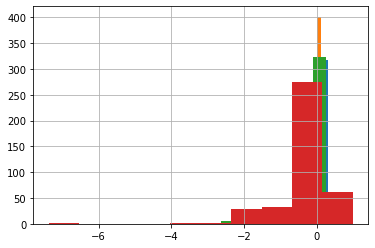

In [23]:
comps = [resultComparison(df, target_df) for df in gdfs.values()]

## In one df

In [53]:
def dfCleanerHelper(k, df):    
    # put date in column
    df['date'] = k
    # return appropriate columns
    return(df.loc[:,['date','KRS','AGS','halte.ges','halte.nv','halte.ges.SFL','halte.nv.SFL']])

In [79]:
long_df = pd.concat([dfCleanerHelper(k, df) for (k, df) in zip(gdfs.keys(), gdfs.values())])

In [80]:
long_df

,date,KRS,AGS,halte.ges,halte.nv,halte.ges.SFL,halte.nv.SFL
0,20220214,Flensburg,1001,25900.306709,25889.143770,928.708541,928.308271
1,20220214,Kiel,1002,67964.424920,67947.731629,1052.967591,1052.708963
2,20220214,Lübeck,1003,48893.249201,48884.338658,615.284251,615.172118
3,20220214,Neumünster,1004,16983.313099,16965.932907,467.452679,466.974302
4,20220214,Dithmarschen,1051,21920.990415,21917.501597,138.278368,138.256361
...,...,...,...,...,...,...,...
396,20211015,Saalfeld-Rudolstadt,16073,15130.636676,15128.126761,168.529153,168.501197
397,20211015,Saale-Holzland-Kreis,16074,6961.041376,6950.197183,88.941991,88.803434
398,20211015,Saale-Orla-Kreis,16075,6662.084507,6662.084507,72.330939,72.330939
399,20211015,Greiz,16076,9456.394366,9456.394366,89.427454,89.427454


## Variabilit"at in Kreisen

In [103]:
meds = long_df.groupby('AGS').median().sort_values('AGS').merge(long_df[['AGS','KRS']].drop_duplicates('AGS'), on='AGS')

In [105]:
stds = long_df.groupby('AGS').std(ddof=0).sort_values('AGS').merge(long_df[['AGS','KRS']].drop_duplicates('AGS'), on='AGS')

In [110]:
pd.concat([stds[['AGS','KRS']],stds.loc[:,'halte.ges':'halte.nv.SFL']/meds.loc[:,'halte.ges':'halte.nv.SFL']],axis=1).sort_values('halte.ges.SFL',ascending=False)

,AGS,KRS,halte.ges,halte.nv,halte.ges.SFL,halte.nv.SFL
276,9476,Kronach,2.958923,2.965483,2.958923,2.965483
85,5370,Heinsberg,1.356704,1.357497,1.356704,1.357497
61,4011,Bremen,0.930179,0.932093,0.930179,0.932093
366,15003,Magdeburg,0.883895,0.888666,0.883895,0.888666
390,16067,Gotha,0.804820,0.809194,0.804820,0.809194
...,...,...,...,...,...,...
293,9662,Schweinfurt,0.004363,0.004272,0.004363,0.004272
124,6435,Main-Kinzig-Kreis,0.004105,0.004111,0.004105,0.004111
117,6412,Frankfurt am Main,0.003651,0.003941,0.003651,0.003941
247,9263,Straubing,0.003122,0.003180,0.003122,0.003180


Abweichung Target von Mittel

In [120]:
target = long_df[long_df.date==20220425].sort_values('AGS')

(target - median)/median

In [130]:
pd.set_option('display.max_rows', 500)
med_dev_df = pd.concat([stds[['AGS','KRS']],(target.loc[:,'halte.ges':'halte.nv.SFL']-meds.loc[:,'halte.ges':'halte.nv.SFL'])/meds.loc[:,'halte.ges':'halte.nv.SFL']],axis=1).sort_values('halte.ges.SFL',ascending=False)
bad_med_dev = med_dev_df[med_dev_df['halte.ges.SFL'].abs()>0.1]
bad_med_dev

,AGS,KRS,halte.ges,halte.nv,halte.ges.SFL,halte.nv.SFL
267,9461,Bamberg,0.287082,0.287972,0.287082,0.287972
392,16069,Hildburghausen,0.212504,0.212504,0.212504,0.212504
146,7134,Birkenfeld,0.209953,0.209953,0.209953,0.209953
279,9479,Wunsiedel i. Fichtelgebirge,0.205362,0.205180,0.205362,0.205180
307,9764,Memmingen,0.150589,0.151376,0.150589,0.151376
187,8127,Schwäbisch Hall,0.146272,0.146284,0.146272,0.146284
30,3255,Holzminden,0.141382,0.141382,0.141382,0.141382
12,1060,Segeberg,0.139446,0.139446,0.139446,0.139446
114,5974,Soest,0.116744,0.116863,0.116744,0.116863
344,13004,Schwerin,0.106903,0.107064,0.106903,0.107064


In [135]:
len(bad_med_dev)

65

Abweichung Target von letztem Jahr

In [132]:
pd.set_option('display.max_rows', 500)
last = long_df[long_df.date==20211015].sort_values('AGS')
yr_dev_df = pd.concat([target[['AGS','KRS']],(target.loc[:,'halte.ges':'halte.nv.SFL']-last.loc[:,'halte.ges':'halte.nv.SFL'])/meds.loc[:,'halte.ges':'halte.nv.SFL']],axis=1).sort_values('halte.ges.SFL',ascending=False)
bad_yr_dev = yr_dev_df[yr_dev_df['halte.ges.SFL'].abs()>0.1]
print(len(bad_yr_dev))
bad_yr_dev

206


,AGS,KRS,halte.ges,halte.nv,halte.ges.SFL,halte.nv.SFL
267,9461,Bamberg,1.141914,1.145705,1.141914,1.145705
357,14625,Bautzen,0.994738,0.994611,0.994738,0.994611
135,6611,Kassel,0.988702,0.990642,0.988702,0.990642
356,14612,Dresden,0.988009,0.988458,0.988009,0.988458
138,6633,Kassel,0.982679,0.982694,0.982679,0.982694
351,14511,Chemnitz,0.976491,0.976493,0.976491,0.976493
141,6636,Werra-Meißner-Kreis,0.975062,0.975170,0.975062,0.975170
352,14521,Erzgebirgskreis,0.959407,0.959405,0.959407,0.959405
359,14627,Meißen,0.956048,0.956730,0.956048,0.956730
355,14524,Zwickau,0.954191,0.954187,0.954191,0.954187


In [134]:
bad_med_dev[bad_med_dev['AGS'].isin(bad_yr_dev['AGS'])].sort_values('KRS')

,AGS,KRS,halte.ges,halte.nv,halte.ges.SFL,halte.nv.SFL
143,7131,Ahrweiler,-0.449255,-0.450055,-0.449255,-0.450055
144,7132,Altenkirchen (Westerwald),-0.363805,-0.363805,-0.363805,-0.363805
225,9171,Altötting,-0.365400,-0.365400,-0.365400,-0.365400
368,15082,Anhalt-Bitterfeld,-0.290549,-0.291023,-0.290549,-0.291023
267,9461,Bamberg,0.287082,0.287972,0.287082,0.287972
329,12060,Barnim,-0.118599,-0.118487,-0.118599,-0.118487
146,7134,Birkenfeld,0.209953,0.209953,0.209953,0.209953
92,5554,Borken,-0.152401,-0.152562,-0.152401,-0.152562
204,8315,Breisgau-Hochschwarzwald,-0.431740,-0.432899,-0.431740,-0.432899
61,4011,Bremen,-0.273837,-0.274351,-0.273837,-0.274351


In [27]:
# select relevant columns
df.loc[:,'KRS':'AGS'].concat(df.loc[:,'halte.ges':'

,KRS,AGS
0,Flensburg,1001
1,Kiel,1002
2,Lübeck,1003
3,Neumünster,1004
4,Dithmarschen,1051
...,...,...
396,Saalfeld-Rudolstadt,16073
397,Saale-Holzland-Kreis,16074
398,Saale-Orla-Kreis,16075
399,Greiz,16076


In [175]:
twice_bad = badCities1[1].loc[:,['KRS','diff.ges','diff.nv','diff.ges.per','diff.ges.per.abs','diff.nv.per','diff.nv.per.abs']
                 ].merge(badCities4[1].loc[:,['KRS','diff.ges','diff.nv','diff.ges.per','diff.ges.per.abs','diff.nv.per','diff.nv.per.abs']],
                         on='KRS',
                         suffixes=('_feb','_jun')
                )

In [176]:
twice_bad[np.sign(twice_bad['diff.ges_feb'])==np.sign(twice_bad['diff.ges_jun'])]

,KRS,diff.ges_feb,diff.nv_feb,diff.ges.per_feb,diff.ges.per.abs_feb,diff.nv.per_feb,diff.nv.per.abs_feb,diff.ges_jun,diff.nv_jun,diff.ges.per_jun,diff.ges.per.abs_jun,diff.nv.per_jun,diff.nv.per.abs_jun
2,Koblenz,5713.008349,5720.150449,0.709587,0.709587,0.714988,0.714988,18444.570252,18439.063543,1.340041,1.340041,1.343907,1.343907
4,Mayen-Koblenz,6078.148359,6079.733523,0.644094,0.644094,0.645409,0.645409,20394.881683,20393.692403,1.314536,1.314536,1.315748,1.315748
6,Mönchengladbach,10478.841307,10482.677040,0.558293,0.558293,0.558841,0.558841,33101.523713,33097.982836,1.131743,1.131743,1.131920,1.131920
7,Rhein-Hunsrück-Kreis,2077.516112,2077.516112,0.558015,0.558015,0.558015,0.558015,7555.295616,7555.295616,1.302510,1.302510,1.302510,1.302510
8,Rhein-Lahn-Kreis,2648.942387,2648.942387,0.549453,0.549453,0.549453,0.549453,8508.733333,8508.733333,1.139054,1.139054,1.139054,1.139054
11,Westerwaldkreis,1458.709502,1462.375748,0.541392,0.541392,0.549572,0.549572,4779.709017,4774.173429,1.150883,1.150883,1.157850,1.157850
13,Cochem-Zell,1583.059178,1583.059178,0.529303,0.529303,0.529303,0.529303,4905.483209,4905.483209,1.072496,1.072496,1.072496,1.072496
25,Tuttlingen,2567.647195,2569.579011,0.426042,0.426042,0.429437,0.429437,8278.314945,8273.729837,0.963222,0.963222,0.967328,0.967328
36,Bielefeld,8396.639372,8402.273656,0.301611,0.301611,0.302844,0.302844,20363.721122,20356.860295,0.561976,0.561976,0.563171,0.563171
38,Höxter,1699.795001,1698.251634,0.281503,0.281503,0.281404,0.281404,6361.478044,6364.025115,0.822100,0.822100,0.822952,0.822952


## Vergleich zu letztem Jahr

### Oktober

In [127]:
filenames = [data_dir+p for p in ['nah-fern-211015_kre.stops.4326.geojson','20220610-150005_20220425_fahrplaene_gesamtdeutschland_gtfs.KRS.geojson']]

In [128]:
gdfs = [gpd.read_file(filename) for filename in filenames]

In [129]:
gdfs[0].insert(0,'KRS',gdfs[0]['Raumeinheit'])
gdfs[0].insert(2,'halte.nv',gdfs[0]['n.nv'])
gdfs[0].insert(2,'halte.ges',gdfs[0]['n.nv']+gdfs[0]['n.fv'])

Median percent difference:  -0.01499238997321428
Median average deviation:  2.193383814944538


<AxesSubplot:>

,KRS,AGS,halte.ges_0,halte.nv_0,halte.ges_1,halte.nv_1,diff.ges,diff.nv,diff.ges.per,diff.ges.per.abs,diff.nv.per,diff.nv.per.abs
135,"Kassel, Stadt",6611,634.865100,516.309859,59743.691358,59604.938272,59108.826258,59088.628412,93.104545,93.104545,114.444122,114.444122
138,Kassel,6633,582.760563,582.760563,41062.786008,41061.399177,40480.025445,40478.638614,69.462534,69.462534,69.460154,69.460154
356,"Dresden, Stadt",14612,3982.700315,3870.394366,181615.851852,181427.312757,177633.151537,177556.918391,44.601184,44.601184,45.875666,45.875666
141,Werra-Meißner-Kreis,6636,695.396202,692.070423,30641.012346,30641.012346,29945.616144,29948.941923,43.062669,43.062669,43.274414,43.274414
357,Bautzen,14625,1862.028169,1862.028169,61131.189300,61120.913580,59269.161131,59258.885411,31.830432,31.830432,31.824913,31.824913
358,Görlitz,14626,1472.197183,1472.197183,29661.000000,29652.814815,28188.802817,28180.617632,19.147437,19.147437,19.141877,19.141877
359,Meißen,14627,2095.972350,2066.380282,41381.522634,41351.847737,39285.550284,39285.467455,18.743353,18.743353,19.011732,19.011732
355,Zwickau,14524,1921.028169,1921.028169,37147.251029,37142.308642,35226.222860,35221.280473,18.337171,18.337171,18.334599,18.334599
351,"Chemnitz, Stadt",14511,3118.056338,3118.056338,59129.905350,59110.057613,56011.849012,55992.001275,17.963707,17.963707,17.957341,17.957341
352,Erzgebirgskreis,14521,1781.183099,1781.183099,33324.946502,33321.687243,31543.763403,31540.504144,17.709445,17.709445,17.707615,17.707615


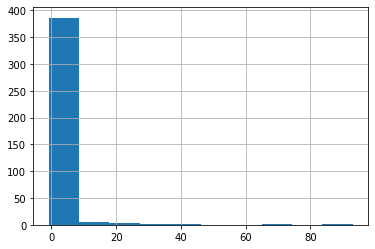

In [130]:
badCities2 = resultComparison(gdfs)

In [131]:
badCities2[1]

,KRS,AGS,halte.ges_0,halte.nv_0,halte.ges_1,halte.nv_1,diff.ges,diff.nv,diff.ges.per,diff.ges.per.abs,diff.nv.per,diff.nv.per.abs
135,"Kassel, Stadt",6611,634.865100,516.309859,59743.691358,59604.938272,59108.826258,59088.628412,93.104545,93.104545,114.444122,114.444122
138,Kassel,6633,582.760563,582.760563,41062.786008,41061.399177,40480.025445,40478.638614,69.462534,69.462534,69.460154,69.460154
356,"Dresden, Stadt",14612,3982.700315,3870.394366,181615.851852,181427.312757,177633.151537,177556.918391,44.601184,44.601184,45.875666,45.875666
141,Werra-Meißner-Kreis,6636,695.396202,692.070423,30641.012346,30641.012346,29945.616144,29948.941923,43.062669,43.062669,43.274414,43.274414
357,Bautzen,14625,1862.028169,1862.028169,61131.189300,61120.913580,59269.161131,59258.885411,31.830432,31.830432,31.824913,31.824913
...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Münster, Stadt",5515,71149.744045,71090.676056,52156.415638,52086.596708,-18993.328407,-19004.079349,-0.266949,0.266949,-0.267322,0.267322
114,Soest,5974,25445.300323,25433.492958,32171.748971,32164.555556,6726.448648,6731.062598,0.264349,0.264349,0.264653,0.264653
349,Vorpommern-Greifswald,13075,15069.246419,15047.507042,19020.242798,18995.399177,3950.996379,3947.892135,0.262189,0.262189,0.262362,0.262362
96,Warendorf,5570,26410.042254,26410.042254,19573.942387,19571.629630,-6836.099867,-6838.412624,-0.258845,0.258845,-0.258932,0.258932


### Anderer Datensatz mit Oktober verglichen

In [134]:
filenames = [data_dir+p for p in ['nah-fern-211015_kre.stops.4326.geojson','20220720-121230_20220214_fahrplaene_gesamtdeutschland_gtfs.KRS.geojson']]

In [135]:
gdfs = [gpd.read_file(filename) for filename in filenames]

gdfs[0].insert(0,'KRS',gdfs[0]['Raumeinheit'])
gdfs[0].insert(2,'halte.nv',gdfs[0]['n.nv'])
gdfs[0].insert(2,'halte.ges',gdfs[0]['n.nv']+gdfs[0]['n.fv'])

Median percent difference:  -0.018391194024960915
Median average deviation:  2.195556999920869


<AxesSubplot:>

,KRS,AGS,halte.ges_0,halte.nv_0,halte.ges_1,halte.nv_1,diff.ges,diff.nv,diff.ges.per,diff.ges.per.abs,diff.nv.per,diff.nv.per.abs
135,"Kassel, Stadt",6611,634.865100,516.309859,59824.798722,59688.680511,59189.933622,59172.370652,93.232300,93.232300,114.606316,114.606316
138,Kassel,6633,582.760563,582.760563,41415.335463,41415.335463,40832.574900,40832.574900,70.067498,70.067498,70.067498,70.067498
356,"Dresden, Stadt",14612,3982.700315,3870.394366,177962.233227,177833.060703,173979.532912,173962.666337,43.683812,43.683812,44.947013,44.947013
141,Werra-Meißner-Kreis,6636,695.396202,692.070423,30781.977636,30781.977636,30086.581434,30089.907213,43.265381,43.265381,43.478100,43.478100
357,Bautzen,14625,1862.028169,1862.028169,60103.792332,60101.000000,58241.764163,58238.971831,31.278670,31.278670,31.277170,31.277170
358,Görlitz,14626,1472.197183,1472.197183,29732.466454,29730.281150,28260.269271,28258.083967,19.195981,19.195981,19.194497,19.194497
359,Meißen,14627,2095.972350,2066.380282,41707.638978,41677.830671,39611.666628,39611.450389,18.898945,18.898945,19.169487,19.169487
351,"Chemnitz, Stadt",14511,3118.056338,3118.056338,61536.143770,61533.322684,58418.087432,58415.266346,18.735418,18.735418,18.734513,18.734513
355,Zwickau,14524,1921.028169,1921.028169,37518.747604,37517.952077,35597.719435,35596.923908,18.530556,18.530556,18.530142,18.530142
352,Erzgebirgskreis,14521,1781.183099,1781.183099,34096.900958,34096.581470,32315.717860,32315.398371,18.142839,18.142839,18.142659,18.142659


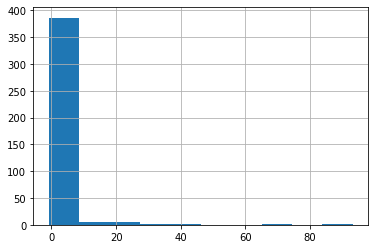

In [137]:
badCities3 = resultComparison(gdfs)